# Validation Notebook
Performs the following validations to expose the model's strengths and weaknesses
- Hold-Out
- Stratified K-Fold
- Repeated Stratified K-Fold
- Stratified Shuffle Split
- LOGO (Leave-One-Group-Out)

## Imports/Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    StratifiedShuffleSplit
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [2]:
from datetime import datetime
import os

# Output folders
REPORT_DIR = "validation_reports"
IMG_DIR = os.path.join(REPORT_DIR, "images")
os.makedirs(REPORT_DIR, exist_ok=True)
os.makedirs(IMG_DIR, exist_ok=True)
MODEL_IN_USE = "combined_6"

EXPERIMENT_ID = f"validation_summary_{MODEL_IN_USE}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"


## Load and Combine Data

In [3]:
# Load all C2 and normal traffic
normal_path = "../../data/normal_only/normal_1.csv"
c2_only_paths = [
    "../../data/c2_only/metasploit_only.csv",
    "../../data/c2_only/covenant_only.csv",
    "../../data/c2_only/empire_only.csv",
    "../../data/c2_only/sliver_only.csv",
    "../../data/c2_only/merlin_only.csv",
    "../../data/c2_only/posh_only.csv"
]

mixed_paths = [
    "../../data/mixed/metasploit_mixed_1.csv",
    "../../data/mixed/covenant_mixed_0.csv",
    "../../data/mixed/empire_mixed_0.csv",
    "../../data/mixed/posh_mixed_0.csv"
]

# Load normal
normal_df = pd.read_csv(normal_path)

# Load C2-only traffic
c2_only_df = pd.concat([pd.read_csv(path) for path in c2_only_paths], ignore_index=True)

# Load only C2-labeled packets from mixed datasets
mixed_c2_df = pd.concat(
    [pd.read_csv(path).query("c2_label == 1") for path in mixed_paths],
    ignore_index=True
)

# Combine true C2 traffic
c2_df = pd.concat([c2_only_df, mixed_c2_df], ignore_index=True)

# Target ratio
desired_c2_ratio = 0.2
desired_normal_ratio = 0.8
normal_needed = int((len(c2_df) / desired_c2_ratio) * desired_normal_ratio)

# Balance dataset
if normal_needed > len(normal_df):
    actual_total = len(normal_df) + len(c2_df)
    actual_c2_ratio = len(c2_df) / actual_total
    actual_normal_ratio = len(normal_df) / actual_total

    print(f"[!] Not enough normal traffic to enforce 20:80 C2:Normal ratio.")
    print(f"[!] Using all {len(normal_df)} normal packets instead.")
    print(f"[!] Actual ratio: {actual_c2_ratio:.2%} C2 / {actual_normal_ratio:.2%} Normal")

    normal_df_sampled = normal_df
else:
    normal_df_sampled = normal_df.sample(n=normal_needed, random_state=42)
    print(f"[+] Subsampled normal traffic to {normal_needed} rows to maintain 20:80 class balance.")

# Final balanced dataframe
df = pd.concat([normal_df_sampled, c2_df], ignore_index=True)
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)


[!] Not enough normal traffic to enforce 20:80 C2:Normal ratio.
[!] Using all 249057 normal packets instead.
[!] Actual ratio: 20.96% C2 / 79.04% Normal


## Define Features and Labels

In [4]:
X = df.drop(columns=["c2_label"])
y = df["c2_label"]


## Evaluate Function

In [5]:
def evaluate_model(X_train, X_test, y_train, y_test, label="", plot=False, return_roc=False):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    if len(model.classes_) == 2:
        y_probs = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_probs = np.full_like(y_test, fill_value=model.classes_[0], dtype=np.float64)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_probs)
    report = classification_report(y_test, y_pred, output_dict=True)

    fpr, tpr, _ = roc_curve(y_test, y_probs)

    result = {
        "label": label,
        "accuracy": acc,
        "auc": auc,
        "report": report,
        "y_test": y_test,
        "y_pred": y_pred
    }


    if plot:
        # === ROC Curve ===
        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC (AUC = {auc:.2f})")
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve – {label}")
        plt.legend()
        plt.tight_layout()
        roc_path = os.path.join(IMG_DIR, f"{label.replace(' ', '_')}_roc.png")
        plt.savefig(roc_path)
        result["roc_img"] = os.path.join("images", os.path.basename(roc_path))
        plt.close()

        # === Feature Importance ===
        if isinstance(X_train, pd.DataFrame):
            feature_names = X_train.columns
        else:
            feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

        importances = model.feature_importances_
        sorted_idx = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 5))
        sns.barplot(x=importances[sorted_idx], y=[feature_names[i] for i in sorted_idx])
        plt.title(f"Feature Importance – {label}")
        plt.tight_layout()
        feat_path = os.path.join(IMG_DIR, f"{label.replace(' ', '_')}_feature_importance.png")
        plt.savefig(feat_path)
        result["feature_img"] = os.path.join("images", os.path.basename(feat_path))
        plt.close()

        # === Prediction Histogram ===
        plt.figure(figsize=(8, 5))
        sns.histplot(y_probs[y_test == 0], bins=20, kde=True, color="green", label="Normal", alpha=0.5)
        sns.histplot(y_probs[y_test == 1], bins=20, kde=True, color="red", label="C2", alpha=0.5)
        plt.title(f"Prediction Probabilities – {label}")
        plt.xlabel("Probability of C2")
        plt.legend()
        plt.tight_layout()
        hist_path = os.path.join(IMG_DIR, f"{label.replace(' ', '_')}_histogram.png")
        plt.savefig(hist_path)
        result["hist_img"] = os.path.join("images", os.path.basename(hist_path))
        plt.close()

    if return_roc:
        result["fpr"] = fpr
        result["tpr"] = tpr

    result["y_test"] = y_test
    result["y_pred"] = y_pred


    return result


## Hold-Out Validation

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
holdout_result = evaluate_model(X_train, X_test, y_train, y_test,
                                label="Hold-Out", plot=True, return_roc=True)


## Stratified K-Fold Validation

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_kfold = []
kfold_rocs = []

for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    r = evaluate_model(
        X.iloc[train_idx], X.iloc[test_idx],
        y.iloc[train_idx], y.iloc[test_idx],
        label=f"K-Fold {i+1}", plot=False, return_roc=True
    )
    results_kfold.append(r)
    kfold_rocs.append((r["fpr"], r["tpr"], r["auc"]))


## Repeated Stratified K-Fold

In [8]:
from sklearn.model_selection import RepeatedStratifiedKFold

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
results_repeated = []
repeated_rocs = []

for i, (train_idx, test_idx) in enumerate(rskf.split(X, y)):
    r = evaluate_model(
        X.iloc[train_idx], X.iloc[test_idx],
        y.iloc[train_idx], y.iloc[test_idx],
        label=f"Repeated K-Fold {i+1}", plot=False, return_roc=True
    )
    results_repeated.append(r)  # Save full result dict
    repeated_rocs.append((r["fpr"], r["tpr"], r["auc"]))  # Save ROC data separately


## Stratified Shuffle Split

In [9]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.4, random_state=42)
results_shuffle = []

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.4, random_state=42)
results_shuffle = []
shuffle_rocs = []

for i, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    r = evaluate_model(
        X.iloc[train_idx], X.iloc[test_idx],
        y.iloc[train_idx], y.iloc[test_idx],
        label=f"Shuffle Split {i+1}", plot=False, return_roc=True
    )
    results_shuffle.append(r)  # Save full result dict
    shuffle_rocs.append((r["fpr"], r["tpr"], r["auc"]))  # Save ROC data separately



## Leave One Group Out (LOGO)

In [10]:
from sklearn.model_selection import LeaveOneGroupOut
import pandas as pd
import os

# === Setup ===
normal_path = "../../data/normal_only/normal_1.csv"
normal_df = pd.read_csv(normal_path)

# Mapping framework to its C2-only and mixed datasets
framework_sources = {
    "metasploit": [
        "../../data/c2_only/metasploit_only.csv",
        "../../data/mixed/metasploit_mixed_1.csv"
    ],
    "covenant": [
        "../../data/c2_only/covenant_only.csv",
        "../../data/mixed/covenant_mixed_0.csv"
    ],
    "empire": [
        "../../data/c2_only/empire_only.csv",
        "../../data/mixed/empire_mixed_0.csv"
    ],
    "sliver": [
        "../../data/c2_only/sliver_only.csv",
        "../../data/mixed/sliver_mixed_0.csv",
        "../../data/mixed/sliver_mixed_1.csv"
    ],
    "merlin": [
        "../../data/c2_only/merlin_only.csv",
        "../../data/mixed/merlin_mixed_0.csv"
    ],
    "posh": [
        "../../data/c2_only/posh_only.csv",
        "../../data/mixed/posh_mixed_0.csv"
    ]
}

logo_results = []
logo_rocs = []

# === Iterate over frameworks, holding one out ===
for held_out_name in framework_sources:
    # === Split C2 and Normal for test set ===
    test_c2_df = pd.concat([
        df[df["c2_label"] == 1] for df_path in framework_sources[held_out_name]
        for df in [pd.read_csv(df_path)]
    ], ignore_index=True)

    test_normal_needed = int((len(test_c2_df) / 0.2) * 0.8)
    if len(normal_df) >= test_normal_needed:
        test_normal_df = normal_df.sample(n=test_normal_needed, random_state=42)
        print(f"[{held_out_name.upper()}] Sampled {test_normal_needed} normal packets for test set.")
    else:
        test_normal_df = normal_df.copy()
        actual_ratio = len(test_c2_df) / (len(test_c2_df) + len(test_normal_df))
        print(f"[{held_out_name.upper()}] Not enough normal traffic for test. Using {actual_ratio:.2%} C2 instead of 20%.")

    test_df = pd.concat([test_c2_df, test_normal_df], ignore_index=True)

    # === Build training set from all other frameworks ===
    train_c2_dfs = []
    for other_name, paths in framework_sources.items():
        if other_name == held_out_name:
            continue
        for path in paths:
            df = pd.read_csv(path)
            train_c2_dfs.append(df[df["c2_label"] == 1])

    train_c2_df = pd.concat(train_c2_dfs, ignore_index=True)

    train_normal_needed = int((len(train_c2_df) / 0.2) * 0.8)
    if len(normal_df) >= train_normal_needed:
        train_normal_df = normal_df.sample(n=train_normal_needed, random_state=1337)
        print(f"[{held_out_name.upper()}] Sampled {train_normal_needed} normal packets for train set.")
    else:
        train_normal_df = normal_df.copy()
        actual_ratio = len(train_c2_df) / (len(train_c2_df) + len(train_normal_df))
        print(f"[{held_out_name.upper()}] Not enough normal traffic for training. Using {actual_ratio:.2%} C2 instead of 20%.")

    train_df = pd.concat([train_c2_df, train_normal_df], ignore_index=True)

    # === Split & Evaluate ===
    X_train = train_df.drop(columns=["c2_label"])
    y_train = train_df["c2_label"]

    X_test = test_df.drop(columns=["c2_label"])
    y_test = test_df["c2_label"]

    r = evaluate_model(X_train, X_test, y_train, y_test,
                       label=f"LOGO_{held_out_name}", plot=False, return_roc=True)

    logo_results.append(r)
    logo_rocs.append((r["fpr"], r["tpr"], r["auc"]))


[METASPLOIT] Sampled 42568 normal packets for test set.
[METASPLOIT] Sampled 233976 normal packets for train set.
[COVENANT] Sampled 53828 normal packets for test set.
[COVENANT] Sampled 222716 normal packets for train set.
[EMPIRE] Sampled 47300 normal packets for test set.
[EMPIRE] Sampled 229244 normal packets for train set.
[SLIVER] Sampled 48932 normal packets for test set.
[SLIVER] Sampled 227612 normal packets for train set.
[MERLIN] Sampled 38252 normal packets for test set.
[MERLIN] Sampled 238292 normal packets for train set.
[POSH] Sampled 45664 normal packets for test set.
[POSH] Sampled 230880 normal packets for train set.


## Generate ROC Comparison Plot

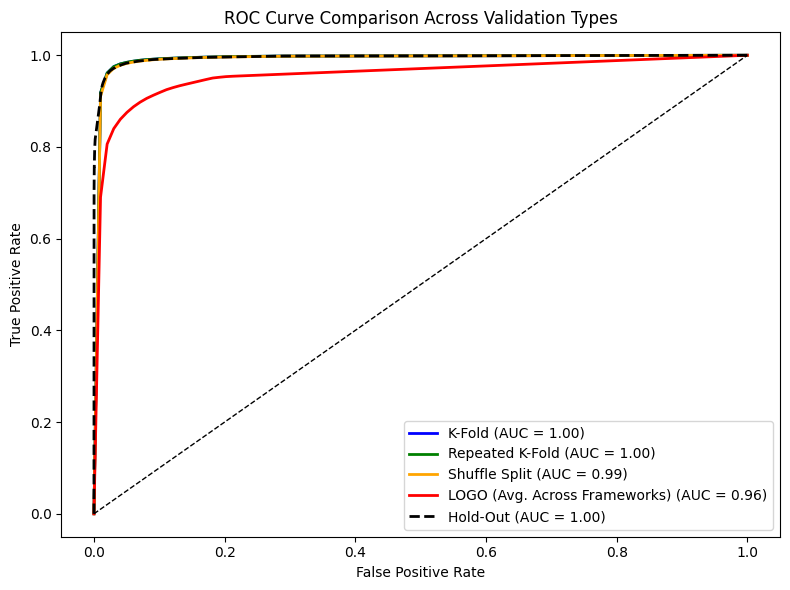

In [11]:
def plot_average_roc_curve(rocs, label, color):
    mean_fpr = np.linspace(0, 1, 100)
    tprs, aucs = [], []

    for fpr, tpr, auc in rocs:
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)

    plt.plot(mean_fpr, mean_tpr, lw=2, label=f"{label} (AUC = {mean_auc:.2f})", color=color)

plt.figure(figsize=(8, 6))
plot_average_roc_curve(kfold_rocs, "K-Fold", "blue")
plot_average_roc_curve(repeated_rocs, "Repeated K-Fold", "green")
plot_average_roc_curve(shuffle_rocs, "Shuffle Split", "orange")

plot_average_roc_curve(logo_rocs, "LOGO (Avg. Across Frameworks)", "red")
plt.plot(
    holdout_result["fpr"],
    holdout_result["tpr"],
    label=f"Hold-Out (AUC = {holdout_result['auc']:.2f})",
    color="black",
    linestyle="--",
    lw=2
)


plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison Across Validation Types")
plt.legend()
plt.tight_layout()

roc_comparison_path = os.path.join(IMG_DIR, f"{EXPERIMENT_ID}_roc_comparison.png")
plt.savefig(roc_comparison_path)
plt.show()


## Combine All Results

In [12]:
combined_results = (
    [holdout_result] +
    results_kfold +
    results_repeated +
    results_shuffle +
    logo_results
)


## Final Summary

In [13]:
def summarize_by_type(results):
    summary_rows = {}
    for r in results:
        label = r["label"]
        if "K-Fold" in label:
            group = "K-Fold"
        elif "Repeated" in label:
            group = "Repeated K-Fold"
        elif "Shuffle" in label:
            group = "Shuffle Split"
        elif "LOGO" in label:
            group = r["label"]  # Keep LOGO separate per framework
        else:
            group = r["label"]

        if group not in summary_rows:
            summary_rows[group] = {
                "F1 (C2)": [],
                "Recall (C2)": [],
                "AUC": []
            }

        summary_rows[group]["F1 (C2)"].append(r["report"]["1"]["f1-score"])
        summary_rows[group]["Recall (C2)"].append(r["report"]["1"]["recall"])
        summary_rows[group]["AUC"].append(r["auc"])

    rows = []
    for label, metrics in summary_rows.items():
        rows.append({
            "Run": label,
            "F1 (C2)": np.mean(metrics["F1 (C2)"]),
            "Recall (C2)": np.mean(metrics["Recall (C2)"]),
            "AUC": np.mean(metrics["AUC"]),
        })

    summary_df = pd.DataFrame(rows)
    display(summary_df.sort_values("F1 (C2)", ascending=False).reset_index(drop=True))
    return summary_df

summary_by_type = summarize_by_type(combined_results)




,Run,F1 (C2),Recall (C2),AUC
0,K-Fold,0.944931,0.938032,0.995360
1,Hold-Out,0.942911,0.935844,0.995013
2,Shuffle Split,0.942154,0.934769,0.994823
3,LOGO_posh,0.924757,0.886563,0.996098
4,LOGO_empire,0.905345,0.852939,0.993741
5,LOGO_covenant,0.884796,0.817567,0.973070
6,LOGO_metasploit,0.731114,0.593403,0.974144
7,LOGO_merlin,0.570476,0.411377,0.903667
8,LOGO_sliver,0.348782,0.217772,0.910770


## Export Summary

In [14]:
from datetime import datetime
from sklearn.metrics import classification_report

# Final output path
report_path = os.path.join(REPORT_DIR, f"{EXPERIMENT_ID}.md")

with open(report_path, "w") as f:
    f.write(f"# Validation Summary Report\n\n")
    f.write(f"**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

    for r in combined_results:
        # Skip all non-Holdout and non-LOGO results
        if r["label"] != "Hold-Out" and not r["label"].startswith("LOGO_"):
            continue

        # Section header
        if r["label"] == "Hold-Out":
            f.write("## Full Model Evaluation (Hold-Out)\n\n")
        elif r["label"].startswith("LOGO_"):
            framework = r["label"].split("_")[1].capitalize()
            f.write(f"## Generalization to {framework} (LOGO)\n\n")
        else:
            f.write(f"## {r['label']}\n\n")

        f.write(f"- Accuracy: `{r['accuracy']:.4f}`\n")
        f.write(f"- AUC: `{r['auc']:.4f}`\n\n")

        # Classification report
        f.write("### Classification Report\n")
        f.write("```\n")
        y_test = r.get("y_test")
        y_pred = r.get("y_pred")

        if y_test is not None and y_pred is not None:
            f.write(classification_report(y_test, y_pred))
        else:
            f.write("Classification report unavailable.\n")
        f.write("```\n\n")

        # Only Hold-Out gets the plots
        if r["label"] == "Hold-Out":
            if "roc_img" in r:
                f.write(f"### ROC Curve\n")
                f.write(f"![ROC Curve]({r['roc_img']})\n\n")
            if "feature_img" in r:
                f.write(f"### Feature Importance\n")
                f.write(f"![Feature Importance]({r['feature_img']})\n\n")
            if "hist_img" in r:
                f.write(f"### Prediction Probability Distribution\n")
                f.write(f"![Prediction Histogram]({r['hist_img']})\n\n")

    # ROC curve comparison
    f.write("## ROC Curve Comparison\n\n")
    f.write(f"![ROC Comparison](images/{os.path.basename(roc_comparison_path)})\n\n")

    # Averaged metrics
    f.write("---\n")
    f.write("## Validation Metrics Summary (Folds and Shuffle Runs Averaged)\n\n")
    f.write(summary_by_type.to_markdown(index=False))
    f.write("\n")

print(f"Markdown report saved to: {report_path}")


Markdown report saved to: validation_reports\validation_summary_combined_6_2025-05-19_20-16-36.md
